In [15]:
# NOTE: the default pyvisa import works well for Python 3.6+
# if you are working with python version lower than 3.6, use 'import visa' instead of import pyvisa as visa

import pyvisa as visa
import time
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt



In [16]:
%matplotlib ipympl

In [17]:
file_name = 'Cap2000'

save_path = "D:\\PHD\\research\\Test\\LCR\data"

# Get today's date
today = datetime.today().strftime("%Y-%m-%d")

folder_name = os.path.join(save_path, f"{today}")

os.makedirs(folder_name, exist_ok=True)

#  if test capacitor, using 'CPRP'; if test inducdance, using 'LSRS'
test_mode = 'CPRP'

long_freq = 1
time_delay = 50000


if long_freq==1:


    f = np.logspace(np.log10(20), np.log10(300e3), 50)

    freq_list = np.round(f, 2)

    # freq_list = f[:,np.newaxis]

    # freq_list = [20, 100, 1000, 10000, 100000, 300000]
  
    print(freq_list[:, np.newaxis].transpose())
    
else:
    freq_list = np.array( [20, 100, 1000, 10000, 100000, 300000])


[[2.0000000e+01 2.4340000e+01 2.9610000e+01 3.6030000e+01 4.3850000e+01
  5.3350000e+01 6.4920000e+01 7.9000000e+01 9.6130000e+01 1.1697000e+02
  1.4233000e+02 1.7319000e+02 2.1074000e+02 2.5643000e+02 3.1203000e+02
  3.7969000e+02 4.6201000e+02 5.6218000e+02 6.8408000e+02 8.3240000e+02
  1.0128800e+03 1.2324900e+03 1.4997200e+03 1.8248900e+03 2.2205600e+03
  2.7020200e+03 3.2878700e+03 4.0007500e+03 4.8681900e+03 5.9237200e+03
  7.2081000e+03 8.7709600e+03 1.0672670e+04 1.2986720e+04 1.5802510e+04
  1.9228810e+04 2.3398000e+04 2.8471150e+04 3.4644270e+04 4.2155840e+04
  5.1296070e+04 6.2418080e+04 7.5951580e+04 9.2419400e+04 1.1245778e+05
  1.3684088e+05 1.6651072e+05 2.0261358e+05 2.4654426e+05 3.0000000e+05]]


In [18]:

def sequency_sweep(test_mode, long_frequency, time_delay):
    rm = visa.ResourceManager()
    E4980AL = rm.open_resource('USB0::0x2A8D::0x2F01::MY54415935::0::INSTR')
    E4980AL.write(':FUNCtion:IMPedance:TYPE %s' % (test_mode))
    E4980AL.write(':MEMory:FILL %s' % ('DBUF'))
    E4980AL.write(':LIST:MODE %s' % ('SEQuence'))

    if long_frequency==1:
        E4980AL.write(':LIST:FREQuency %s' % ('2.0000000e+01, 2.4340000e+01, 2.9610000e+01, 3.6030000e+01,\
                                            4.3850000e+01, 5.3350000e+01, 6.4920000e+01, 7.9000000e+01,\
                                            9.6130000e+01, 1.1697000e+02, 1.4233000e+02, 1.7319000e+02,\
                                            2.1074000e+02, 2.5643000e+02, 3.1203000e+02, 3.7969000e+02,\
                                            4.6201000e+02, 5.6218000e+02, 6.8408000e+02, 8.3240000e+02,\
                                            1.0128800e+03, 1.2324900e+03, 1.4997200e+03, 1.8248900e+03,\
                                            2.2205600e+03, 2.7020200e+03, 3.2878700e+03, 4.0007500e+03,\
                                            4.8681900e+03, 5.9237200e+03, 7.2081000e+03, 8.7709600e+03,\
                                            1.0672670e+04, 1.2986720e+04, 1.5802510e+04, 1.9228810e+04,\
                                            2.3398000e+04, 2.8471150e+04, 3.4644270e+04, 4.2155840e+04,\
                                            5.1296070e+04, 6.2418080e+04, 7.5951580e+04, 9.2419400e+04,\
                                            1.1245778e+05, 1.3684088e+05, 1.6651072e+05, 2.0261358e+05,\
                                            2.4654426e+05, 3.0000000e+05'))
    else:
        E4980AL.write(':LIST:FREQuency %s' %
                      ('20, 100, 1000, 10000, 100000, 300000'))
    # E4980AL.write(':LIST:FREQuency %s' % (freq_list))
    E4980AL.write(':TRIGger:SOURce %s' % ('BUS'))
    E4980AL.write(':TRIGger:IMMediate')
    E4980AL.timeout = time_delay
    E4980AL.write(':DISPlay:PAGE %s' % ('LIST'))
    temp_values = E4980AL.query_ascii_values(':MEMory:READ? %s' % ('DBUF'))


    E4980AL.write(':MEMory:CLEar %s' % ('DBUF'))
    E4980AL.write('*CLS')
    E4980AL.close()
    rm.close()

    return temp_values

# end of SWEEP


temp_values = sequency_sweep(test_mode, long_freq, time_delay)


In [19]:


import pickle

data_array = np.array(temp_values).reshape(-1,4)

print(data_array[0])

data = data_array[data_array[:, 2] == 0]

print(data.shape)

save_dic = {}

save_dic['frq'] = freq_list

save_dic[f"{test_mode[:2]}"] = data[:, 0]

save_dic[f"{test_mode[2:]}"] = data[:, 1]

print("data in dic:", "frq", f"{test_mode[:2]}", f"{test_mode[2:]}")

try:

    save_data = np.concatenate((freq_list[:, np.newaxis], data[:,:2]), axis=1)
except ValueError:
    raise Exception( "\n**ERROR - Unable to initialize. Restart the code again**\n")


if long_freq ==1:

    save_name = f"{test_mode}_long_{file_name}.pkl"

    # np.save(os.path.join(folder_name, f"{test_mode}_long_{file_name}.npy"), save_data)
else:
    
    save_name = f"{test_mode}_short_{file_name}.pkl"
    # np.save(os.path.join(folder_name,
    #         f"{test_mode}_short_{file_name}.npy"), save_data)


with open(os.path.join(folder_name,
                       save_name), 'wb') as handle:
    pickle.dump( save_dic, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

# print(f"Data saved at: {save_path}")

# np.save(os.path.join(folder_name,
#         save_name), save_data)

print(save_data[0])

print(save_data.shape)


[1.93811e-03 1.35005e+02 0.00000e+00 0.00000e+00]
(50, 4)
data in dic: frq CP RP
[2.00000e+01 1.93811e-03 1.35005e+02]
(50, 3)


In [20]:
freq_arr = np.array(freq_list)

w = 2 * np.pi * freq_arr  # Angular frequency


def find_z(data, w, test_mode):
    if test_mode == 'CPRP':
        # Extract columns from data
        C = data[:, 0]  # First column (Capacitance)
        R = data[:, 1]  # Second column (Resistance)

        # Compute Impedances
        Z_c = 1 / (w * C * 1j)  # Capacitive impedance
        Z_total = 1 / (1 / R + 1 / Z_c)  # Parallel impedance
        return C, R, Z_total

    elif test_mode == 'LSRS':  # Assuming a different test mode instead of repeating 'CPRP'
        L = data[:, 0]  # Inductor values
        # Resistance values (assuming a second column for resistance)
        R = data[:, 1]

        # Compute Impedance for an RL parallel circuit


        Z_l = 1j * w * L  # Inductive impedance
        Z_total =  R +  Z_l  # Parallel impedance
        return L, R, Z_total

    else:
        raise ValueError("Invalid test mode. Use 'CPRP' or 'LPRP'.")





In [21]:
if test_mode == 'CPRP':
    C, R, Z_total = find_z(data, w, test_mode)
elif test_mode == 'LSRS':

    L, R, Z_total = find_z(data, w, test_mode)

# Compute phase angle in degrees
PHS = np.rad2deg(np.arctan(np.imag(Z_total) / np.real(Z_total)))


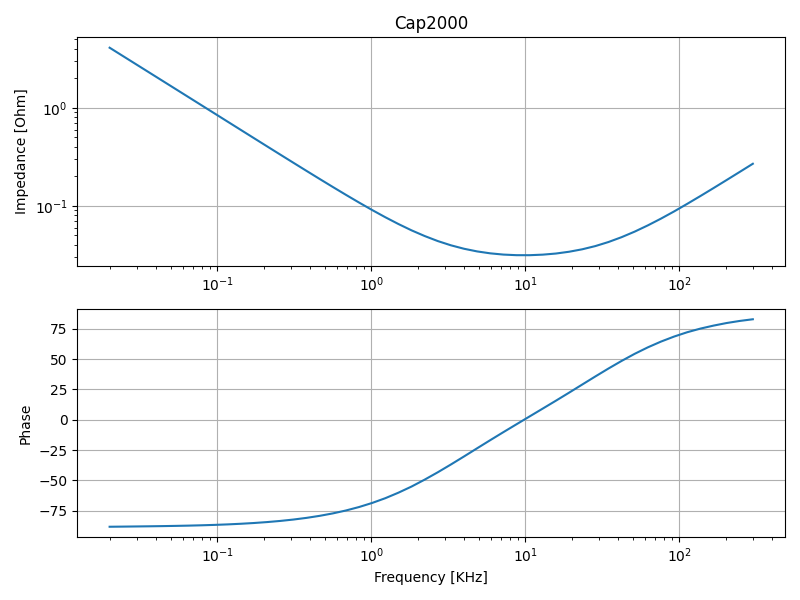

In [22]:
folder_fig = os.path.join(folder_name, "fig")

os.makedirs(folder_fig, exist_ok=True)

save_fig_name = f"{save_name[:-3]}png"

f_kHz = freq_arr / 1000
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# Log-log plot for impedance
axs[0].loglog(f_kHz, np.abs(Z_total))
axs[0].set_title(file_name)  # Replace with title_plot variable
axs[0].set_ylabel("Impedance [Ohm]")
axs[0].grid(True)

# Semilog plot for phase
axs[1].semilogx(f_kHz, PHS)
axs[1].set_xlabel("Frequency [KHz]")
axs[1].set_ylabel("Phase")
axs[1].grid(True)

plt.savefig(os.path.join(folder_fig,
                         save_fig_name), dpi=300, bbox_inches='tight')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


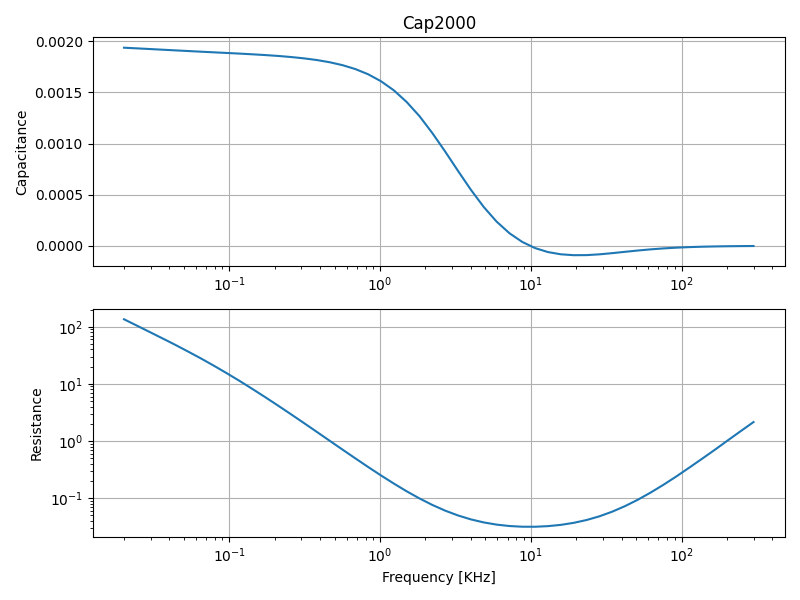

In [23]:


# Frequency scaling
# f_kHz = freq_arr / 1000  # Convert frequency to kHz

# Create a new figure
# plt.figure()
# plt.semilogx(f_kHz, np.abs(Z_pal))  # Plot magnitude of impedance

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  

if test_mode == 'CPRP':

    # 2 rows, 1 column

    # Log-log plot for impedance
    axs[0].semilogx(f_kHz, C)
    axs[0].set_title(file_name)  # Replace with title_plot variable
    axs[0].set_ylabel("Capacitance")
    axs[0].grid(True)

    # Semilog plot for phase
    axs[1].loglog(f_kHz, R)
    axs[1].set_xlabel("Frequency [KHz]")
    axs[1].set_ylabel("Resistance")
    axs[1].grid(True)
elif test_mode == 'LSRS':
    axs[0].semilogx(f_kHz, L)
    axs[0].set_title(file_name)  # Replace with title_plot variable
    axs[0].set_ylabel("Inductance")
    axs[0].grid(True)

    # Semilog plot for phase
    axs[1].loglog(f_kHz, R)
    axs[1].set_xlabel("Frequency [KHz]")
    axs[1].set_ylabel("Resistance")
    axs[1].grid(True)


    # Adjust layout and show plot


plt.tight_layout()
plt.show()
